# Topic Models(Twitter)

Here, three topic models are tested: **Latent Dirichlet Allocation(LDA), Latent Semantic Indexing(LSI), Hierarchical Dirichlet Process(HDP)**.<br>
First, we used the balanced Twitter dataset by down-sampling and up-sampling. After data preprocessing, vocabulary dictionary and document term matrix are built. <br>
We then trained the model by specifying different hyperparameter. Number of topics K is selected based on Silhouette score and human interpretation. Other parameters are selected by trial and error in order to get better result.

In [1]:
import pandas as pd
import numpy as np
import os
import re
import csv
import sys
import time
import string
from IPython.display import Image
from IPython.display import display
import gensim
from gensim import corpora, models, similarities
import nltk
#from nltk import wordpunct_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [2]:
# After Data preprocessing, we use R to balanced the dataset by down-sampling and up-sampling
# The sample dataset is selected by keywords, where each keyword contains 10000 tweets
disease = pd.read_csv('sample_10000.csv', encoding = 'UTF-8', sep = ',', index_col = 0)
df = pd.DataFrame(disease, columns = ['id', 'key', 'created_time', 'language', 'message'])
df.index = range(len(df))
dlang = df
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

with open(
        '10000_preprocessing.csv',
        'w',
        encoding = 'UTF-8',
        newline = '') as csvfile:
    column = [[
        'id', 'key', 'created_time', 'language', 'message', 're_message'
    ]]
    writer = csv.writer(csvfile)
    writer.writerows(column)
for i in range(len(dlang['message'])):
    features = []
    features.append(str(int(dlang['id'][i])))
    features.append(dlang['key'][i])
    features.append(dlang['created_time'][i])
    features.append(dlang['language'][i])
    features.append(dlang['message'][i])
    reurl = re.sub(r"http\S+", "", str(dlang['message'][i]))
    tokens = ' '.join(re.findall(r"[\w']+", reurl)).lower().split()
    x = [''.join(c for c in s if c not in string.punctuation) for s in tokens]
    x=' '.join(x)
    stop_free = " ".join([i for i in x.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word,pos='n') for word in punc_free.split())
    normalized = " ".join(lemma.lemmatize(word,pos='v') for word in normalized.split())
    word = " ".join(word for word in normalized.split() if len(word)>3)
    postag = nltk.pos_tag(word.split())
    irlist = [',','.',':','#',';','CD','WRB','RB','PRP','...',')','(','-','``','@']
    poslist = ['NN','NNP','NNS','RB','RBR','RBS','JJ','JJR','JJS']
    wordlist = ['co', 'https', 'http','rt','com','amp','fe0f','www','ve','dont',"i'm","it's",'isnt','âźă','âąă','âł_','kf4pdwe64k']
    adjandn = [word for word,pos in postag if pos in poslist and word not in wordlist and len(word)>3]
    stop = set(stopwords.words('english'))
    wordlist = [i for i in adjandn if i not in stop]
    features.append(' '.join(wordlist))
    with open('10000_preprocessing.csv', 'a', encoding = 'UTF-8', newline = '') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows([features])
df_postncomment = pd.read_csv('10000_preprocessing.csv', encoding = 'UTF-8', sep = ',')
df_rm = df_postncomment.drop_duplicates(subset = ['id', 're_message'])
rm_english_na = df_rm.dropna()
rm_english_na.index = range(len(rm_english_na))
dfinal_tw = pd.DataFrame(
    rm_english_na,
    columns = ['id', 'key', 'created_time', 'language', 'message', 're_message'])
dfinal_tw.to_csv(
    '10000_twitter_preprocessing.csv',
    encoding = 'UTF-8',
    columns = ['id', 'key', 'created_time', 'language', 'message', 're_message'])
os.remove('10000_preprocessing.csv')

In [3]:
test = pd.read_csv('10000_twitter_preprocessing.csv', encoding = 'UTF-8', sep = ',', index_col = 0)
display(test.head(3))

,id,key,created_time,language,message,re_message
0,872427340885839872,abbvie,2017-06-07T10:17:41.000Z,en,Synlogic Meets First Discovery Milestone in Pa...,synlogic meet first discovery milestone partne...
1,862381755352965120,abbvie,2017-05-10T17:00:07.000Z,en,Read these 5 important facts about glioblastom...,read important fact glioblastoma btam
2,877888425768177664,abbvie,2017-06-22T13:58:05.000Z,en,RT @abbvie: Some kids spend 1/2 the day in fro...,abbvie front screen next week kaboom help


In [4]:
import pickle
import pyLDAvis.gensim as gensimvis
import pyLDAvis
df_postn = pd.read_csv('10000_twitter_preprocessing.csv', encoding = 'UTF-8', 
                       sep = ',', index_col = 0)
df_postn = df_postn.sort_values(['created_time'])
df_postn.index = range(len(df_postn))
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()
def tokenize(doc):
    reurl = re.sub(r"http\S+", "", str(doc))
    tokens = ' '.join(re.findall(r"[\w']+", reurl)).lower().split()
    x = [''.join(c for c in s if c not in string.punctuation) for s in tokens]
    x = ' '.join(x)
    stop_free = " ".join([i for i in x.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word, pos='n') for word in punc_free.split())
    normalized = " ".join(lemma.lemmatize(word, pos='v') for word in normalized.split())
    word = " ".join(word for word in normalized.split() if len(word) > 3)
    postag = nltk.pos_tag(word.split())
    poslist = ['NN', 'NNP', 'NNS', 'RB', 'RBR', 'RBS', 'JJ', 'JJR', 'JJS']
    wordlist = ['co', 'https', 'http', 'rt', 'www', 've', 'dont', "i'm", "it's",'kf4pdwe64k','co', 'https', 'http', 'rt', 'www', 've', 'dont', "i'm", "it's",'kf4pdwe64k','nhttps','cant','didnt']
    adjandn = [word for word, pos in postag if pos in poslist and word not in wordlist and len(word) > 3]
    return ' '.join(adjandn)

import datetime
import dateutil.relativedelta
def dateselect(day):
    d = datetime.datetime.strptime(str(datetime.date.today()), "%Y-%m-%d")
    d2 = d - dateutil.relativedelta.relativedelta(days=day)
    df_time = df_postn['created_time']
    df_time = pd.to_datetime(df_time)
    mask = (df_time > d2) & (df_time <= d)
    period = df_postn.loc[mask]
    return period

corpus = list(df_postn['re_message'])
directory = "doc_clean.txt"
if os.path.exists(directory):
    with open("doc_clean.txt", "rb") as fp:  # Unpickling
        doc_clean = pickle.load(fp)
else:
    doc_clean = [tokenize(doc).split() for doc in corpus]
    with open("doc_clean.txt", "wb") as fp:  #Pickling
        pickle.dump(doc_clean, fp)
directory = "corpus.dict"
if os.path.exists(directory):
    dictionary = corpora.Dictionary.load('corpus.dict')
else:
    dictionary = corpora.Dictionary(doc_clean)
    dictionary.save('corpus.dict')
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
tfidf = models.TfidfModel(doc_term_matrix)
finalcorpus=tfidf[doc_term_matrix]

# Latent Dirichlet Allocation(LDA)

In [5]:
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
ldamodel = LdaModel(finalcorpus, num_topics = 40, id2word = dictionary, 
                    update_every = 10, chunksize = 2000, passes = 10, alpha = 0.05)
ldamodel.save('lda40.model')
import pyLDAvis.gensim as gensimvis
import pyLDAvis
ldamodel = LdaModel.load('lda40.model')
vis_data = gensimvis.prepare(ldamodel, finalcorpus, dictionary)
pyLDAvis.save_html(vis_data, 'lda40.html')
vistopicid = vis_data[6]
idlist = []
for j in range(1, len(vistopicid) + 1):
    idlist.append([i for i, x in enumerate(vistopicid) if x == j][0])
topicwords = {}
no = 0
for prob in ldamodel.show_topics(40,7):
    tokens = ' '.join(re.findall(r"[\w']+", str(prob[1]))).lower().split()
    x = [''.join(c for c in s if c not in string.punctuation) for s in tokens]
    result = ' '.join([i for i in x if not i.isdigit()])
    topicwords[idlist[no]] = result.split()
    no += 1
for i in range(40):
    print("Topic", i+1, ": ", topicwords[i])

Topic 1 :  ['management', 'stake', 'position', 'share', 'abbv', 'capital', 'myers']
Topic 2 :  ['hepatitis', 'infection', 'triple', 'epidemic', 'virus', 'year', 'people']
Topic 3 :  ['bristol', 'myers', 'bristolmyerssquibb', 'read', 'collaboration', 'estimate', 'opdivo']
Topic 4 :  ['trial', 'drug', 'astrazeneca', 'late', 'stage', 'share', 'fall']
Topic 5 :  ['video', 'arthritis', 'rheumatoid', 'heroin', 'arthritisremedies', 'case', 'spike']
Topic 6 :  ['fish', 'arthritis', 'progression', 'rheumatoid', 'early', 'today', 'ibrutinib']
Topic 7 :  ['application', 'data', 'phase', 'amgen', 'regimen', 'image', 'possible']
Topic 8 :  ['amgen', 'quarter', 'revenue', 'earn', 'post', 'profit', 'share']
Topic 9 :  ['court', 'supreme', 'worldhepatitisday', 'limit', 'company', 'food', 'administration']
Topic 10 :  ['arthritis', 'rheumatoid', 'rheum', 'symptom', 'painful', 'ease', 'psoriasis']
Topic 11 :  ['psoriasis', 'suffer', 'skin', 'skincare', 'itchy', 'please', 'eczema']
Topic 12 :  ['biogen',

In [6]:
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
# ldamodel = LdaModel(finalcorpus, num_topics = 30, id2word = dictionary, 
#                     update_every = 10, chunksize = 2000, passes = 10, alpha = 0.05)
# ldamodel.save('lda30.model')
import pyLDAvis.gensim as gensimvis
import pyLDAvis
ldamodel = LdaModel.load('lda30.model')
vis_data = gensimvis.prepare(ldamodel, finalcorpus, dictionary)
pyLDAvis.save_html(vis_data, 'lda30.html')
vistopicid = vis_data[6]
idlist = []
for j in range(1, len(vistopicid) + 1):
    idlist.append([i for i, x in enumerate(vistopicid) if x == j][0])
topicwords = {}
no = 0
for prob in ldamodel.show_topics(30,7):
    tokens = ' '.join(re.findall(r"[\w']+", str(prob[1]))).lower().split()
    x = [''.join(c for c in s if c not in string.punctuation) for s in tokens]
    result = ' '.join([i for i in x if not i.isdigit()])
    topicwords[idlist[no]] = result.split()
    no += 1
for i in range(30):
    print("Topic", i+1, ": ", topicwords[i])
# Save the topic results as a csv file
topics = pd.DataFrame.from_dict(topicwords, orient = 'index')
topics.sort_index(inplace = True)
topics.to_csv('LDA_topics.csv', encoding = 'UTF-8')
# k = pd.read_csv('LDA_topics.csv', encoding='UTF-8', sep=',',index_col=0)
# df = pd.DataFrame(k)
# df.columns=list(range(1,11))
# display(df)

Topic 1 :  ['bristol', 'myers', 'bristolmyerssquibb', 'drug', 'astrazeneca', 'cancer', 'read']
Topic 2 :  ['abbv', 'share', 'stake', 'management', 'position', 'abbvie', 'myers']
Topic 3 :  ['arthritis', 'rheumatoid', 'spondylitis', 'androgel', 'pain', 'joint', 'ankylose']
Topic 4 :  ['hepatitis', 'infection', 'video', 'triple', 'arthritis', 'rheumatoid', 'epidemic']
Topic 5 :  ['spondylitis', 'ankylose', 'psoriasis', 'today', 'news', 'medical', 'diet']
Topic 6 :  ['california', 'tour', 'stage', 'rheumatoid', 'arthritis', 'race', 'disease']
Topic 7 :  ['psoriasis', 'skin', 'testosterone', 'question', 'scalp', 'antiviral', 'wish']
Topic 8 :  ['hepatitis', 'suffer', 'active', 'treatment', 'manufacture', 'evenity', 'itchy']
Topic 9 :  ['vetr', 'bristol', 'myers', 'abbvie', 'global', 'coverage', 'abbv']
Topic 10 :  ['earn', 'amgen', 'target', 'analyst', 'myers', 'bristol', 'animal']
Topic 11 :  ['ibrutinib', 'leukemia', 'cell', 'application', 'biologics', 'patient', 'submit']
Topic 12 :  ['

# Latent Semantic Indexing(LSI)

In [7]:
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
lsimodel = LsiModel(finalcorpus, id2word = dictionary, num_topics = 30,chunksize = 2000)
lsimodel.save('lsi30.model')
topicwords = {}
no = 0
for prob in lsimodel.show_topics(30, 10):
    tokens = ' '.join(re.findall(r"[\w']+", str(prob[1]))).lower().split()
    x = [''.join(c for c in s if c not in string.punctuation) for s in tokens]
    result = ' '.join([i for i in x if not i.isdigit()])
    topicwords[no] = result.split()
    no += 1
for i in range(30):
    print("Topic", i+1, ": ", topicwords[i])

Topic 1 :  ['bristol', 'myers', 'drug', 'cancer', 'arthritis', 'share', 'rheumatoid', 'company', 'hepatitis', 'abbvie']
Topic 2 :  ['arthritis', 'rheumatoid', 'bristol', 'myers', 'hepatitis', 'treatment', 'psoriasis', 'patient', 'drug', 'video']
Topic 3 :  ['hepatitis', 'arthritis', 'rheumatoid', 'infection', 'epidemic', 'drug', 'triple', 'abbvie', 'bristol', 'case']
Topic 4 :  ['abbvie', 'hepatitis', 'abbv', 'amgen', 'trial', 'stage', 'late', 'epidemic', 'infection', 'bristol']
Topic 5 :  ['psoriasis', 'spondylitis', 'ankylose', 'rheumatoid', 'treatment', 'today', 'arthritis', 'medical', 'drug', 'news']
Topic 6 :  ['amgen', 'drug', 'court', 'cancer', 'trial', 'amgn', 'supreme', 'late', 'stage', 'company']
Topic 7 :  ['court', 'supreme', 'limit', 'abbvie', 'abbv', 'company', 'drug', 'spondylitis', 'share', 'psoriasis']
Topic 8 :  ['spondylitis', 'psoriasis', 'ankylose', 'stage', 'treatment', 'late', 'trial', 'court', 'skin', 'supreme']
Topic 9 :  ['amgen', 'abbvie', 'amgn', 'abbv', 'dr

# Hierarchical Dirichlet Process(HDP)

In [8]:
hdpmodel = HdpModel(finalcorpus, id2word = dictionary, T = 30, alpha = 0.05, chunksize = 2000)
hdpmodel.save('hdp.model')
vis_data = gensimvis.prepare(hdpmodel, finalcorpus, dictionary)
#pyLDAvis.display(vis_data)
vistopicid = vis_data[6]
idlist = []
for j in range(1, len(vistopicid) + 1):
    idlist.append([i for i, x in enumerate(vistopicid) if x == j][0])
topicwords = {}
no = 0
for prob in hdpmodel.show_topics(30,7):
    tokens = ' '.join(re.findall(r"[\w']+", str(prob[1]))).lower().split()
    x = [''.join(c for c in s if c not in string.punctuation) for s in tokens]
    result = ' '.join([i for i in x if not i.isdigit()])
    topicwords[idlist[no]] = result.split()
    no += 1
for i in range(30):
    print("Topic", i+1, ": ", topicwords[i])

Topic 1 :  ['efficacy', 'kiranshaw', 'nreuters', 'eclecticv', 'stevehowley1974', 'ogutozgur', 'variation']
Topic 2 :  ['biome', 'sensory', 'cookchildrens', 'climate', 'bhivebiotek', 'moriartylab', 'variety']
Topic 3 :  ['womb', 'zjemptv', 'airedalenhsft', 'discount', 'thedermeditor', 'parliament', 'sitifat']
Topic 4 :  ['bornthisway', 'louis', 'frankleeplain', 'siliconrepublic', 'quashaag', 'arthroplasty', 'adfam']
Topic 5 :  ['annavanderbreggen', 'emjdermatology', 'chemorefractoriness', 'carolyn', 'bacterial', 'finale', 'inside']
Topic 6 :  ['seatonelementaryschool', 'crocker', 'banknote', 'eyeli', 'bankholiday', 'twittertakeover', 'possibil']
Topic 7 :  ['twisted147', 'stopthewait', 'taxpayer', 'pale', 'weekofpossibiliti', 'paudevera', 'stopeatingbees']
Topic 8 :  ['sensanders', 'hr17', 'nilveritas', 'degree', 'muhammad', 'nopinions', 'revitol']
Topic 9 :  ['quarterback', 'intralinks', 'eeojana', 'eharmony', 'scarymommy', 'aghseagles', 'consumeraffairs']
Topic 10 :  ['cauzd', 'teuren

# Coherence Score

Topic models which can come up with topics as a bag of words can be plugged into the **coherence pipeline**. [NMF topic model](https://medium.com/@aneesha/topic-modeling-with-scikit-learn-e80d33668730) created with scikit-learn can also be compared. <br>
In this section, coherence score is implemented based on [gensim.models.coherencemodel](https://radimrehurek.com/gensim/models/coherencemodel.html) and [Exploring the Space of Topic Coherence Measures](http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf).<br>
See also: [News classification with topic models in gensim](https://markroxor.github.io/gensim/static/notebooks/gensim_news_classification.html)

In [9]:
lsitopics = lsimodel.show_topics(30, 10, formatted = False)
hdptopics = hdpmodel.show_topics(30, 10, formatted = False)
ldatopics = ldamodel.show_topics(30, 10, formatted = False)
lsitopic = [[word for word, prob in topic] for topicid, topic in lsitopics]
hdptopic = [[word for word, prob in topic] for topicid, topic in hdptopics]
ldatopic = [[word for word, prob in topic] for topicid, topic in ldatopics]
lsi_coherence = CoherenceModel(topics = lsitopic[:30], texts = doc_clean, dictionary = dictionary, window_size = 10).get_coherence()
hdp_coherence = CoherenceModel(topics = hdptopic[:30], texts = doc_clean, dictionary = dictionary, window_size = 10).get_coherence()
lda_coherence = CoherenceModel(topics = ldatopic[:30], texts = doc_clean, dictionary = dictionary, window_size = 10).get_coherence()

In [10]:
# coherences: list of coherence values
# indices: indices to be used to mark bars.
def evaluate_bar_graph(coherences, indices):
    assert len(coherences) == len(indices)
    n = len(coherences)
    x = np.arange(n)
    plt.bar(x, coherences, width = 0.2, tick_label = indices, align = 'center')
    plt.xlabel('Models')
    plt.ylabel('Coherence Value')
    plt.savefig("Coherence_tw.png", dpi = 100)
    plt.show()

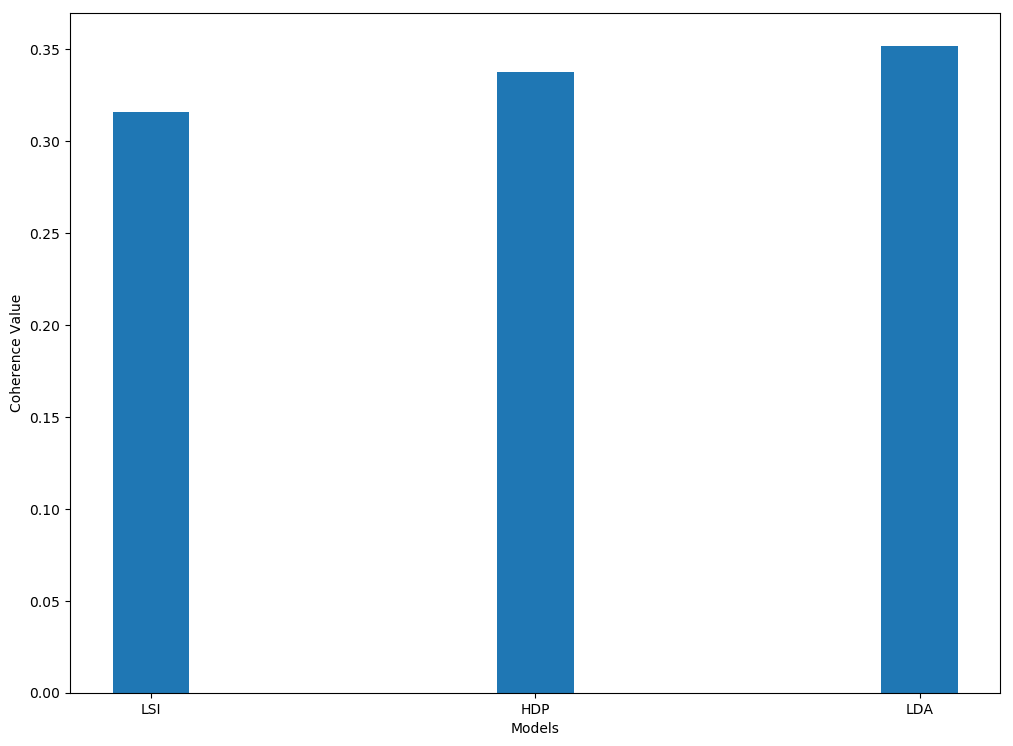

In [11]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (12,9), dpi = 100)
evaluate_bar_graph([lsi_coherence, hdp_coherence, lda_coherence],
                   ['LSI', 'HDP', 'LDA'])